# バンディットの基本

参考：
* [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)
* [バンディット問題の理論とアルゴリズム](https://www.amazon.co.jp/%E3%83%90%E3%83%B3%E3%83%87%E3%82%A3%E3%83%83%E3%83%88%E5%95%8F%E9%A1%8C%E3%81%AE%E7%90%86%E8%AB%96%E3%81%A8%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%9C%AC%E5%A4%9A-%E6%B7%B3%E4%B9%9F/dp/406152917X)

バンディット問題の目的は複数のアームの中から最適なアームを見つけ出すことです。
最適なアームにかかるコストはリグレットと呼ばれ、これをなるべく小さいオーダーに抑えるのがバンディットアルゴリズムの目標になります。
リグレットにも色々あります ([Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)の83ページ)：

* リグレット：方策$\pi$とバンディット$\nu$のリグレットは $R_n(\pi, \nu)=n\mu^*(\nu) - E[\sum^n_{t=1}X_t]$
* ベイズリグレット：バンディットの集合$\mathcal{E}$の事前分布を$Q$として、$\text{BR}_n(\pi, Q) = \int_{\mathcal{E}} R_n(\pi, \nu) dQ(\nu)$
* ランダムリグレット：$\hat{R}_n = n\mu^* - \sum^n_{t=1} X_t$。確率変数であることに注意。期待値を取るとリグレットになります。
* 擬リグレット：$\bar{R}_n = n\mu^* - \sum^n_{t=1} \mu_{A_t}$。確率変数であることに注意。期待値を取るとリグレットになります。

リグレットに対する方策の目標も色々あります

* 任意の$\nu \in \mathcal{E}$について、$\lim_{n\to \infty} \frac{R_n(\pi, \nu)}{n}=0$
* 任意の$\nu \in \mathcal{E}$について、$R_n(\pi, \nu) \leq C n^p$。ここで$C>0$、$p<1$。
* 任意の$n \in \mathbb{N}$、$\nu \in \mathcal{E}$について、$R_n(\pi, \nu) \leq C(\nu) f(n)$。ここで$C: \mathcal{E} \to [0, \infty)$、$f: \mathbb{N} \to [0, \infty)$。

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: xlabel='step', ylabel='pseudo'>

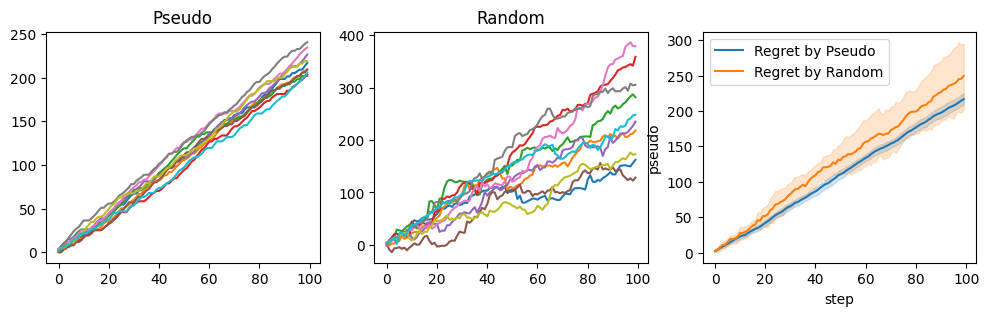

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
Array = np.ndarray

# 適当なガウシアンバンディットを構成してランダムリグレットと擬リグレットを確認します

class GaussianBandit:
    def __init__(self, rew_mean: Array, noise_scale: Array):
        self.rew_mean = rew_mean
        self.noise_scale = noise_scale
        self.optimal_mean = np.max(self.rew_mean)

    def pull(self, arm: int):
        mean = self.rew_mean[arm]
        noise = np.random.randn() * self.noise_scale[arm]
        reward = mean + noise
        return mean, reward


mean_reward = np.array([0.1, 3.0, 1.0, -0.8])
noise_scale = np.array([10.0, 5, 2, 3])

bandit = GaussianBandit(mean_reward, noise_scale)

# 100回引く結果を10回繰り返します
plt.figure(figsize=(12, 3))

pseudo_regrets_seeds = []
random_regrets_seeds = []
steps_seeds = []
for _ in range(10):
    steps = []
    pseudo_regrets = []
    random_regrets = []
    pseudo_regret = 0
    random_regret = 0
    for i in range(100):
        arm = np.random.randint(len(mean_reward))
        mean, rew = bandit.pull(arm)
        pseudo_regret += bandit.optimal_mean - mean
        random_regret += bandit.optimal_mean - rew
        pseudo_regrets.append(pseudo_regret)
        random_regrets.append(random_regret)
        steps.append(i)

    plt.subplot(1, 3, 1)
    plt.plot(pseudo_regrets)
    plt.title("Pseudo")
    plt.subplot(1, 3, 2)
    plt.plot(random_regrets)
    plt.title("Random")

    pseudo_regrets_seeds += pseudo_regrets
    random_regrets_seeds += random_regrets
    steps_seeds += steps

plt.subplot(1, 3, 3)
plt.legend()

df = pd.DataFrame({"step": np.array(steps_seeds), "random": np.array(random_regrets_seeds), "pseudo": np.array(pseudo_regrets_seeds)})
sns.lineplot(data=df, x="step", y="pseudo", label="Regret by Pseudo")
sns.lineplot(data=df, x="step", y="random", label="Regret by Random")

早速いろいろなバンディットアルゴリズムでリグレットがどう変化するか確認してみましょう

# Explore-Then-Commit (ETC) アルゴリズム ([Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)の Chapter 6)

ETCアルゴリズムは次の戦略で最適アームを求めます：
* まず全てのアームを固定した回数だけ引く
* 推定した最も良いアームを引き続ける

これを数式に落とし込んでみます：

$$
A_{t}=\left\{\begin{array}{ll}(t \bmod k)+1, & \text { if } t \leq m k \\ \operatorname{argmax}_{i} \hat{\mu}_{i}(m k), & t>m k\end{array}\right.
$$,

ここで、
* $m$ はアルゴリズムが探索する回数です。
* $k$ はアームの数です。
* $\hat{\mu}_{i}(t)=\frac{1}{T_{i}(t)} \sum_{s=1}^{t} \mathbb{I}\left\{A_{s}=i\right\} X_{s}$ はラウンド$t$の後でのアーム$i$の平均報酬です。

このアルゴリズムのリグレットはどれくらいになるでしょうか？ETCアルゴリズムでは最初の$mk$ラウンドの引き方が固定なので、リグレットを計算するのは結構簡単です。

まず、リグレットを時刻に関する和から、アームについての和で書き換えます。

$$
R_n = \sum^k_{i=1} \Delta_i E[T_i(n)]
$$

ここで$\Delta_i = \mu^* - \mu_i$は最適報酬と$i$ラウンド目の平均報酬の差です。
また、$E[T_i(n)]$は最初の固定された$mk$ラウンドとその後の貪欲なラウンドの和なので、

$$
E[T_i(n)] = m + (n - mk) P (A_{mk+1} =i)
\leq m + (n - mk) P \left(\hat{\mu}_{i}(mk) > \max_{i\neq j}\hat{\mu}_{j}(mk)\right)
$$

最後の項には報酬の推定値$\hat{\mu}$が入っていますね。これは集中不等式によって簡単にバウンドできます (特にノイズがsubgaussianの場合)。結果として、最初の探索フェーズ$m$についてどのように変化するかのリグレットバウンドが導出されます：

$$
R_n \leq m\sum^k_{i=1} \Delta_i + (n-mk) \sum^k_{i=1}\Delta_i \exp \left(- \frac{m\Delta_i^2}{4}\right)
$$

この不等式の右辺を$k=2$のときについて最小化すると、良さそうな$m$の値：$m^*=\max \left\{1,\lceil\frac{4}{\Delta^{2}} \log \left(\frac{n \Delta^{2}}{4}\right)\rceil\right\}$ が得られます。

早速PythonでExplore then commitを試してみます。Bandit AlgorithmsのFigure 6.1を再現してみましょう。

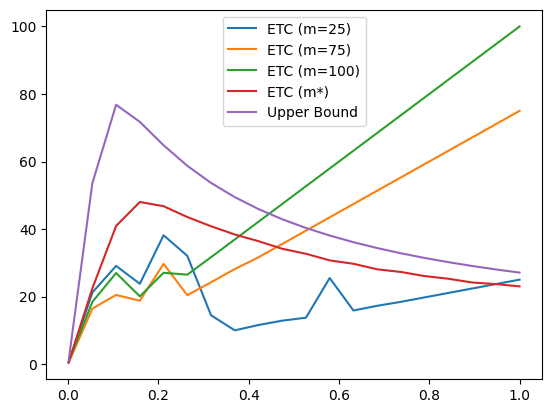

In [9]:
# 2 アームバンディット
# 一方の報酬は０で固定し、もう一方を変化させてRegretを比較

n_step = 1000
k = 2

def explore_then_commit(gap, m, seeds=100):
    bandit = GaussianBandit(np.array([0.0, -gap]), np.ones(k))
    regrets = []
    for _ in range(seeds):
        avg_rewards = np.zeros(k)
        num_arm_pulled = np.zeros(k)

        pseudo_regret = 0
        for i in range(n_step):
            # 行動を選択
            if i <= m * k:
                act = i % k  # 最初の mk ラウンドは探索
            else:
                act = np.argmax(avg_rewards)  # その後は貪欲にarmを選択
            mean, rew = bandit.pull(act)

            # 平均値と探索結果の記録
            num_pulled = num_arm_pulled[act]
            avg_rewards[act] += (rew - avg_rewards[act]) / (num_pulled + 1)
            num_arm_pulled[act] += 1

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)


gaps = np.linspace(0.001, 1.0, 20)
results = {}
for m in [25, 75, 100]:
    regrets = []
    for gap in gaps:
        regrets.append(explore_then_commit(gap, m, seeds=50))
    results[f"ETC (m={m})"] = regrets

regrets = []
for gap in gaps:
    m_star = max(1, np.ceil(4 / (gap ** 2) * np.log(n_step * (gap ** 2) / 4)))  # 最適なm
    regrets.append(explore_then_commit(gap, m_star, seeds=50))
results[f"ETC (m*)"] = regrets

for label, regrets in results.items():
    plt.plot(gaps, regrets, label=label)

upper_bound = np.minimum(n_step * gaps, gaps + 4 / gaps * (1 + np.maximum(0, np.log(n_step * (gaps ** 2) / 4))))
plt.plot(gaps, upper_bound, label="Upper Bound")

plt.legend()

# Upper Confident Bound (UCB) アルゴリズム ([Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)の Chapter 7)

先程のETCアルゴリズムでは最適な$m$の決め方がgap $\Delta$に依存していました。続いてのUCBアルゴリズムはより賢い戦略でアームを選択していきます。
UCBは最適な戦略の一つであり、そうした最適な戦略は「不確かなときほど楽観的な」行動を選択します（OFU principle）。

ETCアルゴリズムは次の戦略で最適アームを求めます：


$$
A_{t}=\operatorname{argmax}_{i} \mathrm{UCB}_{i}(t-1, \delta)
$$
ここで、
$$
\mathrm{UCB}_{i}(t-1, \delta)=\left\{\begin{array}{ll}
\infty & \text { if } T_{i}(t-1)=0 \\
\hat{\mu}_{i}(t-1)+\sqrt{\frac{2 \log (1 / \delta)}{T_{i}(t-1)}} & \text { otherwise }
\end{array}\right.
$$

* $\delta$ はUCBの信頼レベルです。
* $\hat{\mu}_{i}(t)=\frac{1}{T_{i}(t)} \sum_{s=1}^{t} \mathbb{I}\left\{A_{s}=i\right\} X_{s}$ はラウンド$t$でのアーム$i$の平均報酬です。

---

**証明とか**

UCBのアルゴリズムを簡単に説明してみます。まず、$1$-subgaussianな確率変数$X_t$の期待値 $\hat{\mu}=\frac{1}{n} \sum^n_{t=1} X_t$を考えてみます。Subgaussinな確率変数の推定平均値に対しては次のような集中不等式が存在します（Bandit Algorithms 式(5.6))。

$$
P\left(\mu \geq \hat{\mu} + \sqrt{\frac{2 \log(1 / \delta)}{n}}\right) \leq \delta
$$

つまり、本当の$\mu$が$\hat{\mu} + \sqrt{\frac{2 \log(1 / \delta)}{n}}$よりも大きい確率は$\delta$以下なわけです。
UCBはこの式に従って、不確かさも考慮して一番報酬が大きくなりそうなやつを引きます。

UCBの$\delta$の選び方には注意が必要です。今回は$\delta = 1 / n^2$のときのUCBアルゴリズムのリグレットを解析してみましょう。UCBっぽいアルゴリズムは基本的には次の証明でいけます。

1. 簡単のために$\mu_1=\mu^*$とします。これは一般性を失いません。
2. リグレットを書き換えます： $R_n = \sum^k_{i=1} \Delta_i E[T_i(n)]$。それぞれの$i$で$E[T_i(n)]$をバウンドします。
3. UCBアルゴリズムの性能が良いことを示すには、「良いイベントが高い確率で起きる」ことを示せば良いです。ここでいう良いイベントを、「(左) アーム１の平均報酬よりもUCBスコアが常に高く、(右) $i$を$u_i$回引いたときに、アーム$i$のUCBスコアはアーム１の平均報酬よりも低い」とします。こうすると、アーム$i$が引かれる回数をだいたい$u_i$回で抑えることができます。$u_i$は定数で、証明の途中で設計します。
$$
G_i = \left\{\mu_1 < \min_{t\in [n]} \text{UCB}_1(t, \delta)\right\} \cap \left\{\hat{\mu}_{iu_i} + \sqrt{\frac{2}{u_i}\log\left(\frac{1}{\delta}\right)} < \mu_1\right\}
$$
4. このような$G_i$の定義をすると、$G_i$が起きているなら、$T_i(n) \leq u_i$が起きていることを背理法で証明できます。
5. 4を使うと、$E[T_i(n)] = E[{\bf 1}\{G_i\}T_i(n)] + E[{\bf 1}\{G_i^c\}T_i(n)] \leq u_i + P(G_i^c)n$ と変形できます。あとは$P(G_i^c)$が小さくなるように証明します。
6. 
$$
G_i^c = \left\{\mu_1 \geq \min_{t\in [n]} \text{UCB}_1(t, \delta)\right\} \cup \left\{\hat{\mu}_{iu_i} + \sqrt{\frac{2}{u_i}\log\left(\frac{1}{\delta}\right)} \geq \mu_1\right\}
$$
であり、（左）の事象はアームの添字が揃ってるのでUCBの定義と集中不等式で簡単に確率のバウンドが出せます。(右)の事象も$\mu_1 = \mu_i + \Delta_i$によって添字を揃えればこちらも簡単に集中不等式で確率のバウンドが出せます。
7. ゴニョゴニョ変形したり$u_i$を調整したりすると、$E[T_i(n)] \leq 3 + \frac{16\log(n)}{\Delta_i^2}$が示せます。

---

早速PythonでUCBアルゴリズムを試してみます。($\delta = 1 / n^2$にします)
Bandit AlgorithmsのFigure 7.1を再現してみましょう。

/tmp/ipykernel_217858/341558875.py:17: RuntimeWarning: divide by zero encountered in divide
  ucb = np.where(num_arm_pulled == 0, np.infty, avg_rewards + np.sqrt(2 * np.log(n_step**2) / num_arm_pulled))


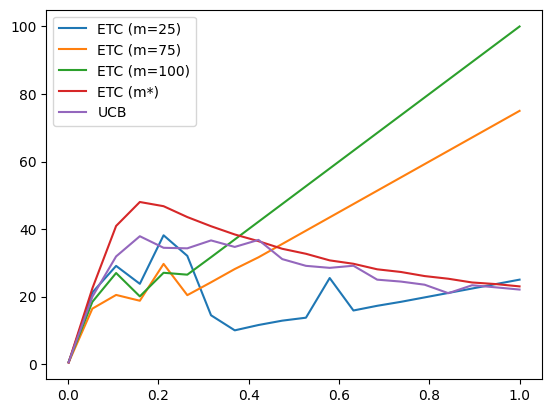

In [14]:
# 2 アームバンディット
# 一方の報酬は０で固定し、もう一方を変化させてRegretを比較

n_step = 1000
k = 2

def upper_confidence_bound(gap, seeds=100):
    bandit = GaussianBandit(np.array([0.0, -gap]), np.ones(k))
    regrets = []
    for _ in range(seeds):
        avg_rewards = np.zeros(k)
        num_arm_pulled = np.zeros(k)

        pseudo_regret = 0
        for i in range(n_step):
            # UCBスコアの計算と行動選択
            ucb = np.where(num_arm_pulled == 0, np.infty, avg_rewards + np.sqrt(2 * np.log(n_step**2) / num_arm_pulled))
            act = np.argmax(ucb)
            mean, rew = bandit.pull(act)

            # 平均値と探索結果の記録
            num_pulled = num_arm_pulled[act]
            avg_rewards[act] += (rew - avg_rewards[act]) / (num_pulled + 1)
            num_arm_pulled[act] += 1

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)

gaps = np.linspace(0.001, 1.0, 20)
regrets = []
for gap in gaps:
    regrets.append(upper_confidence_bound(gap, seeds=50))
results["UCB"] = regrets

for label, regrets in results.items():
    plt.plot(gaps, regrets, label=label)

plt.legend()


先程のUCBアルゴリズムでは$\delta$をホライゾンに依存する$\delta = 1 / n^2$ で設計していました。これはホライゾンが未知のときには困ります。

ホライゾンに依存しないUCBや、もっと良いUCBは [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)の Chapter 8, 9 で紹介されているのでそちらに任せます。


# 敵対的バンディット

統計学者のGeorge E.P. Boxは"All models are wrong; but some are useful" (全てのモデルは間違っている、だが中には役立つものもある)という格言を残しました。
先程まで見てきた確率的バンディットでは、選択された行動に依存する分布から報酬がサンプリングされてきましたが、このモデルはほとんど常に間違っています。
実世界ではもっと複雑な要因が絡み合って報酬が発生します。

確率的バンディットと違って、敵対的バンディットでは最悪ケースの報酬を考えます。つまり、プレイヤーの方策を知っている神のような敵対者が存在して、その敵対者が報酬を設定していると考えます。具体的には次の流れを考えます：

---
1. 敵対者が$\left\{1, \dots, n\right\}$間の報酬を選択します：$(x_t)^n_{t=1}$ with $x_t \in [0, 1]^k$

続いて、時刻 $t=1, \dots, n$で

1. 学習者が行動の選択肢としてあり得る分布 $P_t \in \mathcal{P}_{k-1}$を選択し、行動$A_t$を$P_t$からサンプルします。
2. 報酬 $X_t = x_{tA_t}$ を観測します。

---

敵対者は学習者の方策を知っているので、確率的な方策でない限りは常にリグレットが最悪になってしまいます。なので学習者は分布を選択しているわけですね。

このとき、方策$\pi$と環境$x$について、次のようなリグレットが自然に考えられます:

$$R_n(\pi, x) = \max_{i \in [k]} \sum_{t \in [n]} x_{ti} - E\left[\sum^{n}_{t=1}x_{tA_t}\right]$$

つまり、「敵対者が報酬を決められますが、後から見たときに一番良いアームと比較してどれくらい後悔してる？」っていう量ですね。
実はこのリグレットは確率的バンディットの上界になっています。

$$
\begin{aligned}
R_n(\pi, \nu) &= \max_{i \in [k]} E\left[\sum_{t \in [n]} x_{ti} - \sum^{n}_{t=1}x_{tA_t}\right]\\
 &\leq E\left[\max_{i \in [k]} \sum_{t \in [n]} x_{ti} - \sum^{n}_{t=1}x_{tA_t}\right]\\
 &= E\left[R_n(\pi, x) \right]
 \leq R^*_n(\pi)
\end{aligned}
$$

一行目は確率的バンディットのリグレット、そして最後の行が敵対的バンディットのリグレットです。確率的バンディットの下界が$c\sqrt{nk}$になるので、敵対的バンディットのリグレットの下界もこれで抑えられます。

# EXP3(Exponential-weight algorithm for exploration and exploitation)

敵対的バンディットを解くための最も基本的なアルゴリズムがEXP3です。Exp3は次の流れでアームを選んでいきます。
ここで、$\hat{X}_{ti}=\frac{A_{ti}}{P_{ti}}x_{ti}$、$\hat{S}_{ti}=\sum^t_{s=1}\hat{X}_{si}$ とします。

アーム$i$のLoss-based importance-weighted estimator (p.150参照)を$\hat{S}_{0i}=0$として、
時刻$t =1 \dots n$で、
1. サンプリング用の分布を計算$$P_{ti}=\frac{\exp(\eta\hat{S}_{t-1, i})}{\sum^k_{j=1}\exp(\eta\hat{S}_{t-1, j})}$$
2. アームを選択($A_t \sim P_t$)し、報酬(X_t)を観測:
3. $\hat{S}_{ti}$を更新 
$$\hat{S}_{ti} = \hat{S}_{t-1, i} + 1 - \frac{{\bf 1}\{A_t = i\}(1 - X_t)}{P_{ti}}$$

$\eta = \sqrt{\log(k)/(nk))}$のときにExp3のリグレットが$R_n(\pi, x) \leq 2 \sqrt{nk\log(k)}$で抑えられるのは以下の流れで証明できます。

ステップ1: リグレットを書き換える。

1. $R_{ni}=\sum^n_{t=1} x_{ti} - E\left[\sum^n_{t=1}X_t\right]$として、任意の$i$についてこれをバウンドすることを考えます。どこかの$i$は$\max_i$を含んでいるのでOKです。
2. $E_{t-1}[A_{ti}]=P_{ti}$であり、$P_{ti}$は$t-1$までの情報でmeasurableなので、$E_{t-1}[\hat{X}_{ti}]=x_{ti}$である。
3. 2を使って、$E\left[\hat{S}_{ti}\right]=\sum^n_{t=1}x_{ti}$と$E_{t-1}[X_t] = \sum^{k}_{i=1}P_{ti}x_{ti}=\sum^k_{i=1}P_{ti}E_{t-1}\left[\hat{X}_{ti}\right]$。よって$E\left[\sum^n_{t=1}X_t\right]=E\left[\sum^n_{t=1}\sum^k_{=1}\hat{X}_{ti}\right]$がtower ruleで成立します。
4. 1~3より、$\hat{S}_n=\sum^n_{t=1}\sum^k_{=1}\hat{X}_{ti}$とすると、$R_{ni}=E\left[\hat{S}_{ni}-\hat{S}_n\right]$です。

ステップ2: $\hat{S}_{ni}-\hat{S}_n$をバウンドする。そのために$\hat{S}_{ni}$の上界を求めます。

1. $W_t = \sum^k_{j=1}\exp(\eta\hat{S}_{tj})$とすると、$\exp(\eta \hat{S}_{ni})\leq \sum^k_{j=1}\exp(\eta\hat{S}_{nj})=k\prod^n_{t=1}\frac{W_t}{W_{t-1}}$が成り立ちます。
2. $\frac{W_t}{W_{t-1}}=\sum^k_{j=1}P_{tj}\exp(\eta\hat{X}_{tj})$をバウンドすることを考えます。ここで、$\exp(x) \leq 1 + x + x^2$ for $x \leq 1$、$1 + x \leq \exp(x)$ for $x \in \mathbb{R}$を使います。
3. 2を考えると$\exp(\eta \hat{S}_{ni})\leq k\exp(\eta\hat{S}_n + \eta^2\sum^n_{t=1}\sum^k_{j=1}P_{tj}\hat{X}^2_{tj})$になります。
4. 3より、$\hat{S}_{ni}-\hat{S_n}\leq \log(k)/\eta + \eta\sum^n_{t=1}\sum^k_{i=1}P_{ti}\hat{X}_{ti}^2$になります。

ステップ3: $E[\sum^k_{i=1}P_{ti}\hat{X}_{ti}^2]$をバウンドします。

この証明はすこし面倒なので省略します。直感的には$|X|\leq 1$なので$k$以下になりそうです。実際なります。

ステップ1~3を合体させると所望の結果が得られます。

最後にPythonで実験してみます。
Bandit AlgorithmsのFigure 11.5を再現してみましょう。

100%|██████████| 20/20 [00:28<00:00,  1.41s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


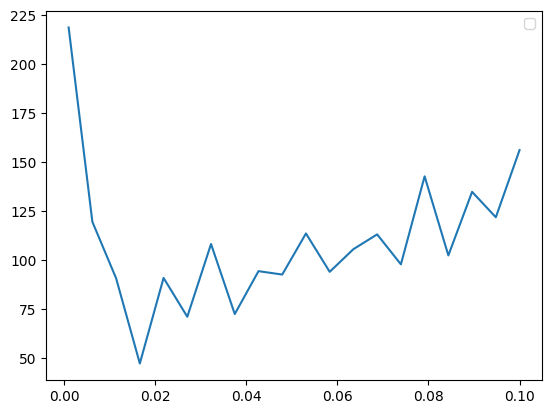

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import special
import seaborn as sns
import pandas as pd
Array = np.ndarray

# 適当なBernoulliバンディットを構成してリグレットを確認します

class BernoulliBandit:
    def __init__(self, rew_mean: Array):
        self.rew_mean = rew_mean
        self.optimal_mean = np.max(self.rew_mean)

    def pull(self, arm: int):
        mean = self.rew_mean[arm]
        reward = np.random.binomial(1, mean)
        return mean, reward


mean_reward = np.array([0.1, 3.0, 1.0, -0.8])
bandit = BernoulliBandit(mean_reward)

n_step = 10000
k = 2

def EXP3(lr, seeds=10):
    bandit = BernoulliBandit(np.array([0.5, 0.5 + 0.05]))
    regrets = []
    for _ in range(seeds):
        total_rewards = np.zeros(k)
        policy = special.softmax(total_rewards * lr)

        pseudo_regret = 0
        for i in range(n_step):
            # 方策から行動の選択
            policy = special.softmax(total_rewards * lr)
            act = np.random.choice(k, p=policy)
            prob = policy[act]
            mean, rew = bandit.pull(act)

            # 方策の更新
            total_rewards += 1
            total_rewards[act] -= (1 - rew) / prob

            # 結果の記録
            pseudo_regret += bandit.optimal_mean - mean
    
        regrets.append(pseudo_regret)
    return np.mean(regrets)

lrs = np.linspace(0.001, 0.1, 20)
regrets = []
for lr in tqdm(lrs):
    regrets.append(EXP3(lr, seeds=10))

plt.plot(lrs, regrets)
plt.legend()